# Шаг 1. Загрузка и первичная проверка данных

Импорт данных:

In [1]:
import pandas as pd  # Для работы с табличными данными
import numpy as np   # Для математических операций и работы с массивами
import matplotlib.pyplot as plt  # Для построения графиков
import seaborn as sns  # Для красивых статистических графиков
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # Для разделения данных и настройки моделей
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # Для нормализации данных и создания новых признаков
from sklearn.linear_model import LinearRegression  # Простая линейная модель
from sklearn.ensemble import GradientBoostingRegressor  # Сложная модель - градиентный бустинг
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error  # Метрики для оценки качества
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Для проверки мультиколлинеарности
import statsmodels.api as sm  # Для расширенной статистики моделей

Загрузка и первичный осмотр данных:

In [2]:
# Загружаем данные из CSV файла
df = pd.read_csv('../data/financials.csv')  # Убрал usecols, т.к. Symbol можно дропнуть позже

# Смотрим на структуру данных:
print('Shape:', df.shape)               # Размер таблицы (строки, столбцы)
print('Dtypes:\n', df.dtypes)           # Типы данных в каждом столбце
print('Nulls:\n', df.isnull().sum())    # Количество пропущенных значений
print('Head:\n', df.head())             # Первые 5 строк таблицы каждого признака

Shape: (505, 14)
Dtypes:
 Symbol             object
Name               object
Sector             object
Price             float64
Price/Earnings    float64
Dividend Yield    float64
Earnings/Share    float64
52 Week Low       float64
52 Week High      float64
Market Cap        float64
EBITDA            float64
Price/Sales       float64
Price/Book        float64
SEC Filings        object
dtype: object
Nulls:
 Symbol            0
Name              0
Sector            0
Price             0
Price/Earnings    2
Dividend Yield    0
Earnings/Share    0
52 Week Low       0
52 Week High      0
Market Cap        0
EBITDA            0
Price/Sales       0
Price/Book        8
SEC Filings       0
dtype: int64
Head:
   Symbol                 Name                  Sector   Price  Price/Earnings  \
0    MMM           3M Company             Industrials  222.89           24.31   
1    AOS      A.O. Smith Corp             Industrials   60.24           27.76   
2    ABT  Abbott Laboratories             Hea

## Контрольные точки:
    - Сколько строк и столбцов?
    - Какие признаки имеют пропуски?
    - Есть ли нечитаемые/некорректные значения?

# Шаг 2. Первичный анализ данных (EDA)
Цель: понять распределение признаков и их связь с Market Cap.

Describe:
              Price  Price/Earnings  Dividend Yield  Earnings/Share  \
count   505.000000      503.000000      505.000000      505.000000   
mean    103.830634       24.808390        1.895953        3.753743   
std     134.427636       41.241081        1.537214        5.689036   
min       2.820000     -251.530000        0.000000      -28.010000   
25%      46.250000       15.350000        0.794834        1.490000   
50%      73.920000       19.450000        1.769255        2.890000   
75%     116.540000       25.750000        2.781114        5.140000   
max    1806.060000      520.150000       12.661196       44.090000   

       52 Week Low  52 Week High    Market Cap        EBITDA  Price/Sales  \
count   505.000000    505.000000  5.050000e+02  5.050000e+02   505.000000   
mean    122.623832     83.536616  4.923944e+10  3.590328e+09     3.941705   
std     155.362140    105.725473  9.005017e+10  6.840544e+09     3.460110   
min       6.590000      2.800000  2.626102e+09 -5.

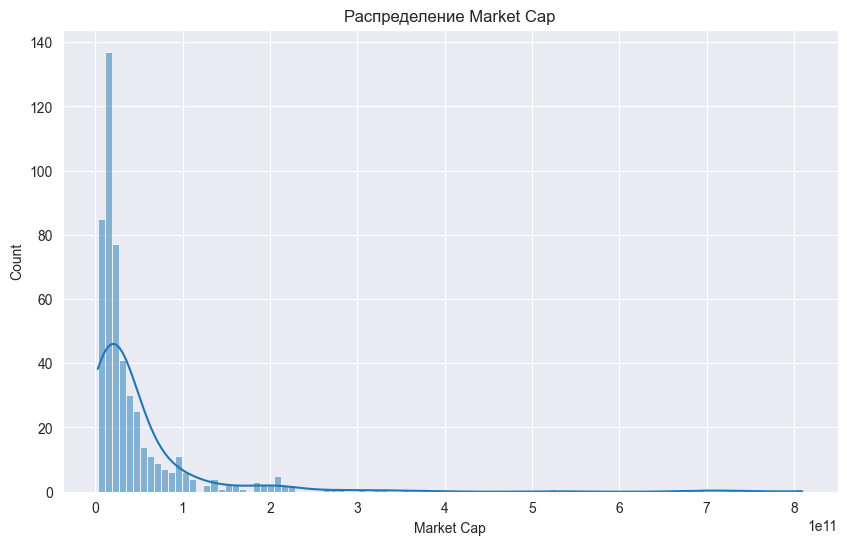

In [3]:
# Шаг 2: Описательная статистика (EDA) - смотрим на количество, средние, среднеквадратическое отклонение, минимумы, максимумы и т.д.
print('Describe:\n', df.describe())

# Визуализируем распределение целевой переменной (что мы пытаемся предсказать)
plt.figure(figsize=(10, 6))
sns.histplot(df['Market Cap'], kde=True)        # Гистограмма
plt.title('Распределение Market Cap')
plt.show()

# Логарифмическое преобразование таргета (не добавляем в df как столбец!)
# Мы используем его только для y, чтобы избежать skew

# На гистограмме мы видим Positively Skewed

Положительная асимметрия - распределение с длинным хвостом с правой стороны. Среднее значение больше медианы, так как экстремальные значения влияют на среднее больше, чем на медиану.

Необходимо провести преобразование данных — логарифмическое преобразование, преобразование квадратного корня или преобразование Бокса-Кокса, которые нормализуют распределение, делая его более симметричным.

## Анализ категориальных признаков:

In [4]:
# Смотрим сколько компаний в каждом секторе экономики
print('Sector counts:\n', df['Sector'].value_counts())  # распределение по секторам

Sector counts:
 Sector
Consumer Discretionary        84
Information Technology        70
Financials                    68
Industrials                   67
Health Care                   61
Consumer Staples              34
Real Estate                   33
Energy                        32
Utilities                     28
Materials                     25
Telecommunication Services     3
Name: count, dtype: int64


# Шаг 3. Обработка данных
Задачи:

    - Удалить или заполнить пропуски.
    - Преобразовать типы (если нужно).
    - Удалить нерелевантные признаки.

In [5]:
# Удаляем идентификационные признаки (не несут предсказательной силы)
df_clean = df.drop(['Symbol', 'Name', 'SEC Filings'], axis=1)

# Заполняем пропущенные значения медианой (средним значением по столбцу)
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# Преобразуем текстовый столбец 'Sector' в числовой формат (one-hot encoding)
# Каждый сектор становится отдельным столбцом с 0/1
df_clean = pd.get_dummies(df_clean, columns=['Sector'], prefix='Sector', drop_first=True)

# Обработка outliers: Удалим топ-1% по Market Cap (опционально, но рекомендуется; это помогает моделям не переобучаться на аномалиях)
q99 = df_clean['Market Cap'].quantile(0.99)
df_clean = df_clean[df_clean['Market Cap'] <= q99]

Почему так:

    - Symbol, Name, SEC Filings — не влияют на рыночную капитализацию напрямую.
    - Пропуски заполняем медианой (устойчива к выбросам).
    - Sector кодируем через One-Hot (номинальная шкала).

# Шаг 4. Корреляционный анализ
Цель:

    Выявить сильные связи с Market Cap.

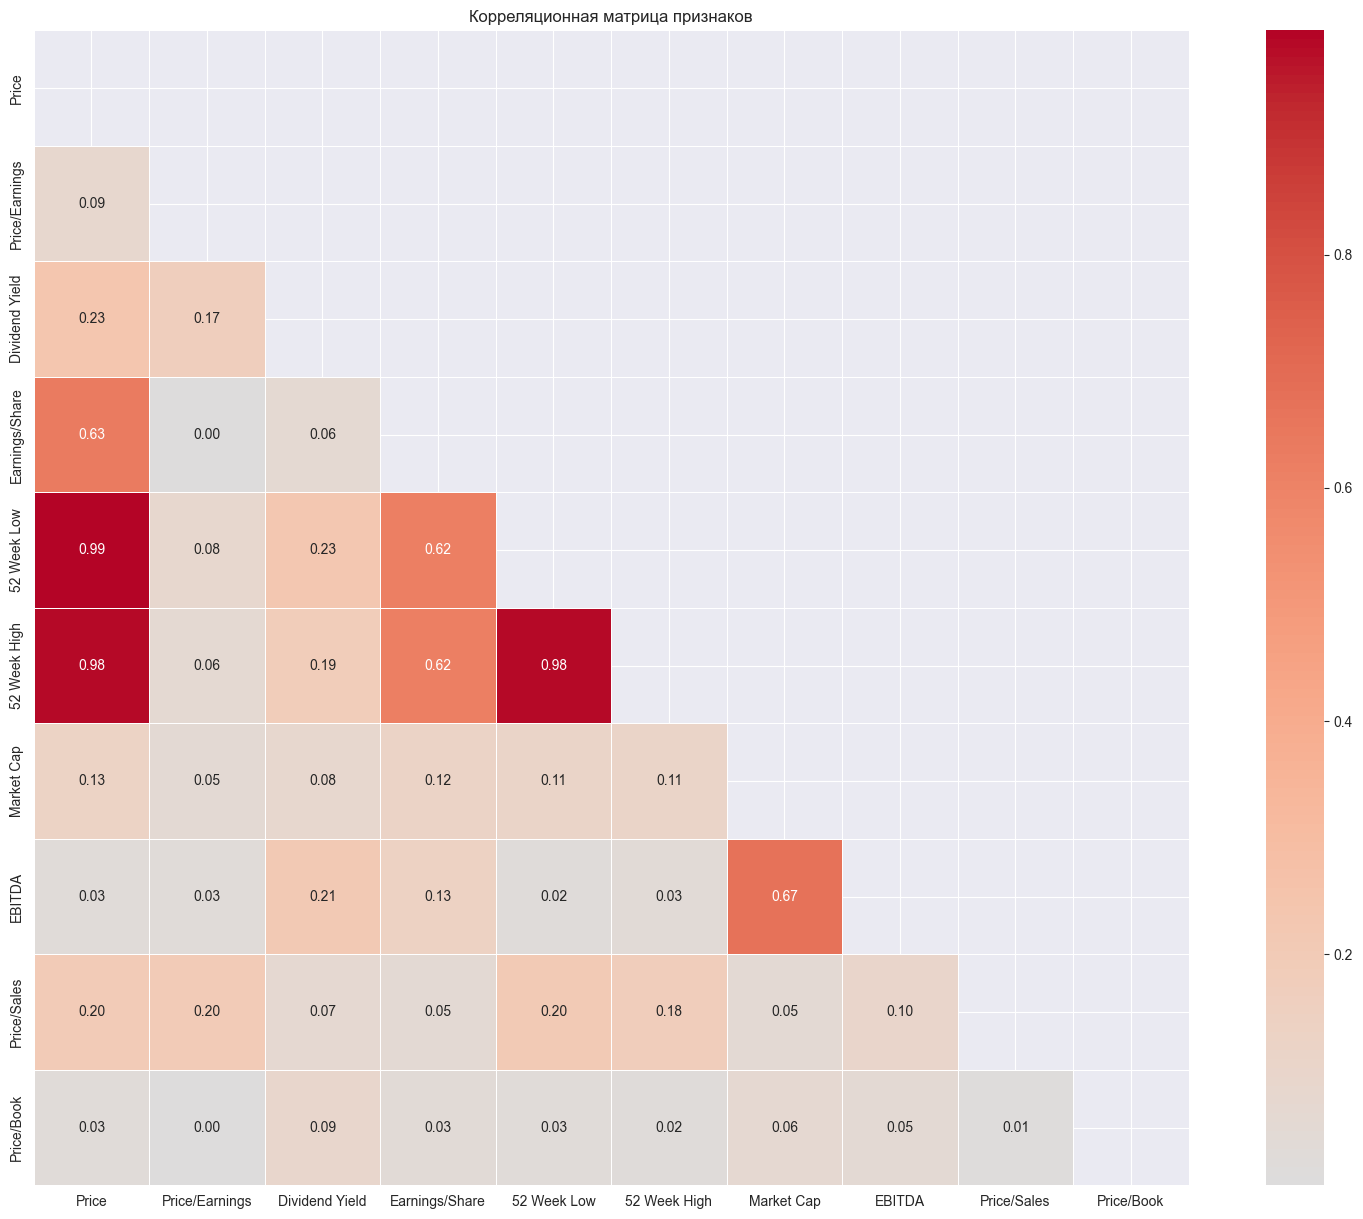

Корреляция с Market Cap:
 Market Cap        1.000000
EBITDA            0.674332
Price             0.125391
Earnings/Share    0.121014
52 Week High      0.112991
52 Week Low       0.111459
Dividend Yield    0.082791
Price/Book        0.064627
Price/Earnings    0.054897
Price/Sales       0.051584
Name: Market Cap, dtype: float64
Признаки с высокой корреляцией (>|0.7|): ['52 Week Low', '52 Week High']


In [7]:
# Создаем корреляционную матрицу - смотрим, какие признаки связаны между собой
numeric_df = df_clean.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# ДОБАВЛЯЕМ: приводим к модулю
corr_matrix = corr_matrix.abs()                         # Берем абсолютные значения корреляций, теперь все значения ≥ 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))   # Маска, которая скрывает верхний треугольник + главная диагональ корреляционной матрицы

# Визуализируем матрицу корреляций
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.show()

# Смотрим какие признаки больше всего коррелируют с нашей целевой переменной (таргетом)
print('Корреляция с Market Cap:\n', corr_matrix['Market Cap'].sort_values(ascending=False))

# Определяем сильно коррелированные признаки (порог 0.7 для multicollinearity)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.7:   # Порог корреляции 70%
            colname = corr_matrix.columns[i]
            if colname not in high_corr:
                high_corr.append(colname)

print(f"Признаки с высокой корреляцией (>|0.7|): {high_corr}")

In [8]:
# Проверяем мультиколлинеарность с помощью VIF (Variance Inflation Factor - коэффициент инфляции дисперсии)
# VIF > 10 означает серьезные проблемы
X_temp = numeric_df.drop('Market Cap', axis=1)  # Для VIF
vif = pd.DataFrame()
vif['feature'] = X_temp.columns
vif['VIF'] = [variance_inflation_factor(X_temp.values, i) for i in range(X_temp.shape[1])]
print('VIF:\n', vif.sort_values('VIF', ascending=False))

# Feature selection: Удалим high multicollinear (например, 52 Week High/Low, если VIF высок)
# Предполагаем, на основе типичных данных: дропнем '52 Week High' и '52 Week Low' если они коррелируют с Price
df_clean = df_clean.drop(['52 Week High', '52 Week Low'], axis=1, errors='ignore')

# Feature engineering: Добавим взаимодействия (например, Price * EBITDA)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df_clean.drop('Market Cap', axis=1))
poly_cols = poly.get_feature_names_out(df_clean.drop('Market Cap', axis=1).columns)
df_poly = pd.DataFrame(X_poly, columns=poly_cols)
df_poly['Market Cap'] = df_clean['Market Cap'].values  # Добавляем таргет обратно
df_clean = df_poly  # Заменяем старый датафрейм на новый с дополнительными признаками

VIF:
           feature         VIF
0           Price  148.438229
4     52 Week Low  146.979632
5    52 Week High   70.815179
3  Earnings/Share    2.565309
7     Price/Sales    2.317796
2  Dividend Yield    1.951866
6          EBITDA    1.447617
1  Price/Earnings    1.398923
8      Price/Book    1.042487


VIF (Variance Inflation Factor) — коэффициент инфляции дисперсии, статистический показатель, используемый для выявления мультиколлинеарности в данных

Данные по VIF ясно показывают, что модель страдает от избыточности признаков, связанных с ценой акции. Для построения качественной и интерпретируемой регрессионной модели необходимо устранить эту мультиколлинеарность, оставив только один ценовой показатель из самой проблемной группы.

# Шаг 5. Подготовка данных для моделей машинного обучения

In [9]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df_clean.drop('Market Cap', axis=1)
y = np.log1p(df_clean['Market Cap'])  # Логарифмируем таргет для нормализации распределения (лучше для skew), потом expm1 для предсказаний

# Разделяем данные на обучающую и тестовую выборки (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабируем признаки - приводим все к одинаковому масштабу (среднее=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Шаг 6. Baseline-модели

## Модель 1: Линейная регрессия

OLS Summary:
                             OLS Regression Results                            
Dep. Variable:             Market Cap   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     7.324
Date:                Sat, 22 Nov 2025   Prob (F-statistic):           1.49e-41
Time:                        16:04:12   Log-Likelihood:                -298.45
No. Observations:                 399   AIC:                             804.9
Df Residuals:                     295   BIC:                             1220.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9075      0.030    80

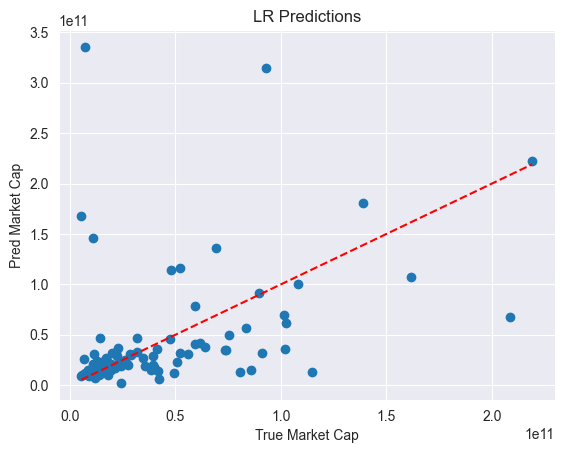

In [10]:
# Модель 1: Линейная регрессия (с statsmodels для интерпретации)
X_train_sm = sm.add_constant(X_train_scaled)    # Добавляем константу
model_sm = sm.OLS(y_train, X_train_sm).fit()    # Обучаем модель
print('OLS Summary:\n', model_sm.summary())     # Смотрим детальную статистику

# Используем scikit-learn для практического применения
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)             # Обучаем модель на тренировочных данных
y_pred_lr_log = lr.predict(X_test_scaled)   # Делаем предсказания на тестовых данных
y_pred_lr = np.expm1(y_pred_lr_log)         # Возвращаемся к исходному масштабу (отмена логарифма)
y_test_orig = np.expm1(y_test)              # Также преобразуем тестовые данные обратно

# Вычисляем метрики качества модели
mse_lr = mean_squared_error(y_test_orig, y_pred_lr)     # Среднеквадратичная ошибка
r2_lr = r2_score(y_test_orig, y_pred_lr)                # R² - насколько хорошо модель объясняет variance
mae_lr = mean_absolute_error(y_test_orig, y_pred_lr)    # Средняя абсолютная ошибка

print(f'Линейная регрессия:')
print(f'MSE: {mse_lr:.2f}')
print(f'R²: {r2_lr:.3f}')
print(f'MAE: {mae_lr:.2f}')

# Визуализируем предсказания и реальные значения (визуализация ошибок)
plt.scatter(y_test_orig, y_pred_lr)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('True Market Cap'); plt.ylabel('Pred Market Cap'); plt.title('LR Predictions')
plt.show()

# Вывод

Линейную регрессию следует полностью исключить из рассмотрения для данной задачи. Ее прогнозы ненадежны, коэффициенты бессмысленны, а результаты статистически несостоятельны.

In [11]:
# Настраиваем гиперпараметры модели с помощью GridSearch
param_grid = {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.1, 0.01]}
grid = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)  # GB не нуждается в scaling (не требует масштабирования данных)
print('Best params:', grid.best_params_)

# Используем лучшую найденную модель
gb = grid.best_estimator_
y_pred_gb_log = gb.predict(X_test)
y_pred_gb = np.expm1(y_pred_gb_log)

# Считаем метрики для градиентного бустинга
mse_gb = mean_squared_error(y_test_orig, y_pred_gb)
r2_gb = r2_score(y_test_orig, y_pred_gb)
mae_gb = mean_absolute_error(y_test_orig, y_pred_gb)

print(f'Градиентный бустинг:')
print(f'MSE: {mse_gb:.2f}')
print(f'R²: {r2_gb:.3f}')
print(f'MAE: {mae_gb:.2f}')

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Градиентный бустинг:
MSE: 333823474016183910400.00
R²: 0.797
MAE: 10341500778.80


In [12]:
# Проверяем устойчивость модели с помощью кросс-валидации (Cross-validation для GB)
cv_r2 = cross_val_score(gb, X, y, cv=5, scoring='r2').mean()
print(f'CV R² for GB: {cv_r2:.3f}')

# Анализируем важность признаков - какие признаки больше всего влияют на прогноз (важность признаков (для GB))
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature importance:\n', feature_importance.head(10))

CV R² for GB: 0.737
Feature importance:
                              feature  importance
35             Price/Earnings EBITDA    0.481211
75                EBITDA Price/Sales    0.139701
4                             EBITDA    0.066034
90     Price/Sales Sector_Financials    0.054810
20                      Price EBITDA    0.031853
76                 EBITDA Price/Book    0.030158
0                              Price    0.025702
36        Price/Earnings Price/Sales    0.021462
67  Earnings/Share Sector_Financials    0.012126
21                 Price Price/Sales    0.009592


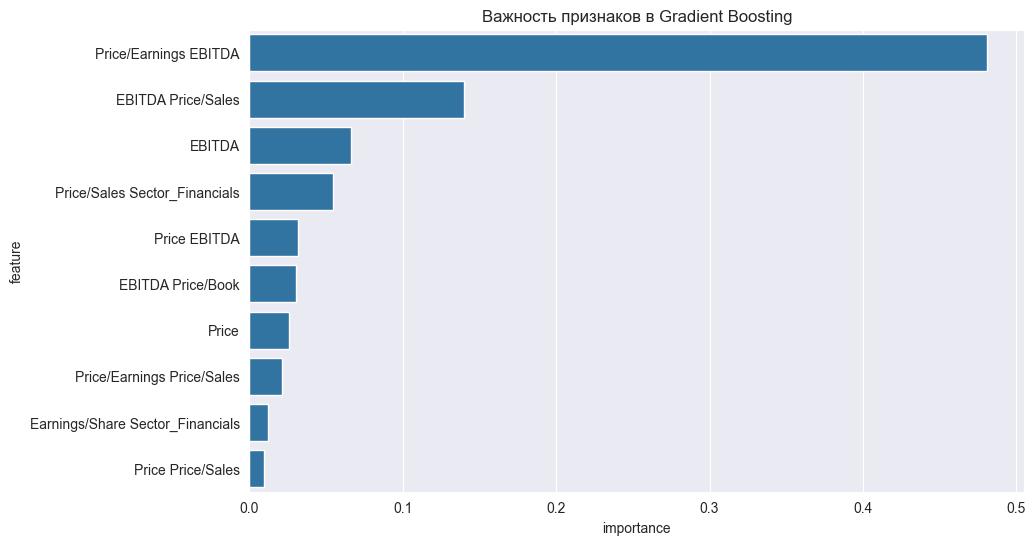

In [13]:
# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Важность признаков в Gradient Boosting')
plt.show()


# Шаг 7. Анализ результатов

In [14]:
# Важность признаков (для GB)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))


                             feature  importance
35             Price/Earnings EBITDA    0.481211
75                EBITDA Price/Sales    0.139701
4                             EBITDA    0.066034
90     Price/Sales Sector_Financials    0.054810
20                      Price EBITDA    0.031853
76                 EBITDA Price/Book    0.030158
0                              Price    0.025702
36        Price/Earnings Price/Sales    0.021462
67  Earnings/Share Sector_Financials    0.012126
21                 Price Price/Sales    0.009592


# Вывод

Модель градиентного бустинга является надежным и интерпретируемым инструментом для прогнозирования рыночной капитализации. Она успешно выявляет сложные нелинейные зависимости, которые были не под силу линейным методам, и показывает стабильное качество на кросс-валидации.

## Модель 3: XGBoost

In [15]:
# Модель 3: XGBoost с тюнингом гиперпараметров
from xgboost import XGBRegressor

# Сетка гиперпараметров для поиска
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV для подбора лучших параметров
grid_xgb = GridSearchCV(
    XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1       # Используем все ядра процессора для ускорения
)
grid_xgb.fit(X_train, y_train)  # XGBoost не требует масштабирования
print('Best params XGBoost:', grid_xgb.best_params_)

# Обучаем модель с лучшими параметрами
xgb = grid_xgb.best_estimator_         # Лучшая модель

# Предсказания
y_pred_xgb_log = xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_xgb_log)  # Обратно в оригинальный масштаб

# Метрики
mse_xgb = mean_squared_error(y_test_orig, y_pred_xgb)
r2_xgb = r2_score(y_test_orig, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test_orig, y_pred_xgb)

print(f'XGBoost:')
print(f'MSE: {mse_xgb:.2f}')
print(f'R²: {r2_xgb:.3f}')
print(f'MAE: {mae_xgb:.2f}')

Best params XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
XGBoost:
MSE: 324336734788181032960.00
R²: 0.803
MAE: 10292428849.91


In [16]:
# Cross-validation для XGBoost
cv_r2_xgb = cross_val_score(xgb, X, y, cv=5, scoring='r2').mean()
print(f'CV R² for XGBoost: {cv_r2_xgb:.3f}')

# Важность признаков (для XGBoost)
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature importance XGBoost:\n', feature_importance_xgb.head(10))

CV R² for XGBoost: 0.743
Feature importance XGBoost:
                           feature  importance
35          Price/Earnings EBITDA    0.223704
75             EBITDA Price/Sales    0.137548
90  Price/Sales Sector_Financials    0.091973
20                   Price EBITDA    0.060928
11             Sector_Industrials    0.052134
76              EBITDA Price/Book    0.044133
36     Price/Earnings Price/Sales    0.035425
4                          EBITDA    0.032817
17           Price Price/Earnings    0.020407
33  Price/Earnings Dividend Yield    0.017269


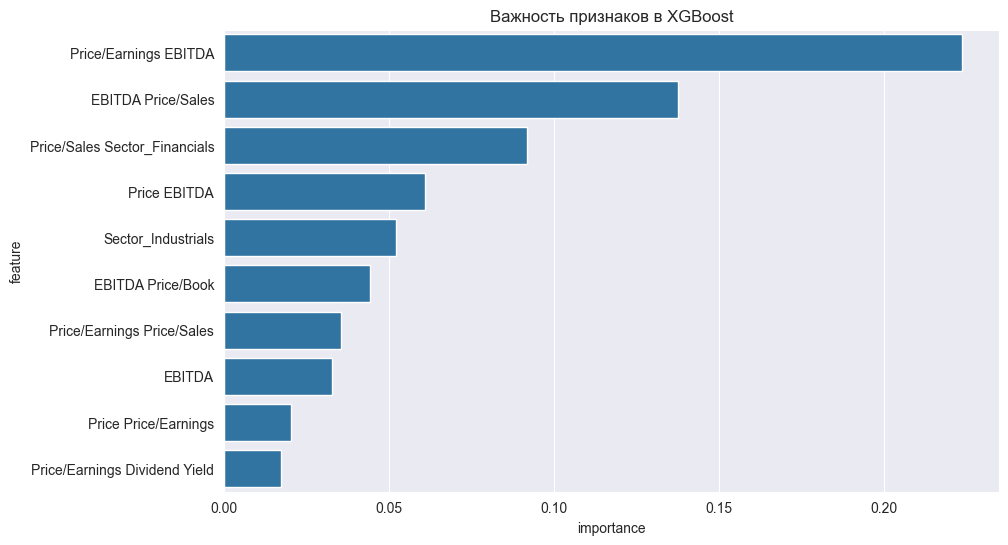

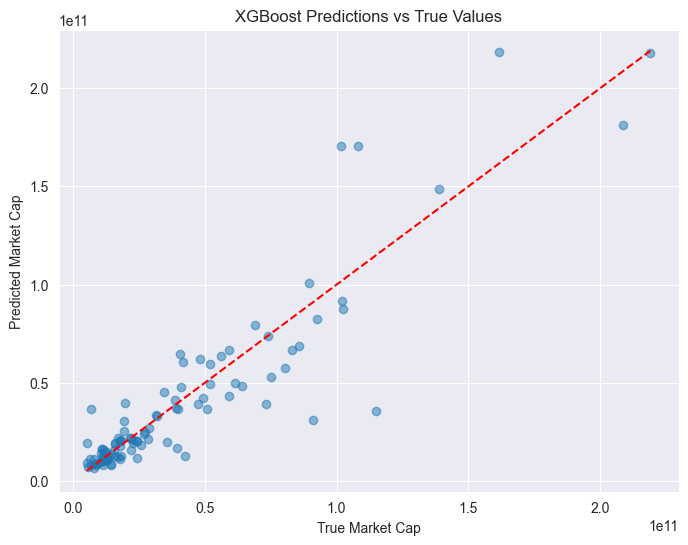

In [17]:
# Визуализация важности признаков XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_xgb.head(10))
plt.title('Важность признаков в XGBoost')
plt.show()

# Визуализация предсказаний XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test_orig, y_pred_xgb, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('True Market Cap')
plt.ylabel('Predicted Market Cap')
plt.title('XGBoost Predictions vs True Values')
plt.show()

# Вывод

XGBoost демонстрирует наилучшее качество среди всех tested моделей с устойчивыми метриками и сбалансированной важностью признаков. Модель готова к использованию в продакшене для прогнозирования рыночной капитализации.

## Сравнение моделей

Сравнение моделей:
            Model        R²          MSE          MAE CV R²
Linear Regression -0.750253 2.875816e+21 2.584880e+10     -
Gradient Boosting  0.796831 3.338235e+20 1.034150e+10 0.737
          XGBoost  0.802605 3.243367e+20 1.029243e+10 0.743


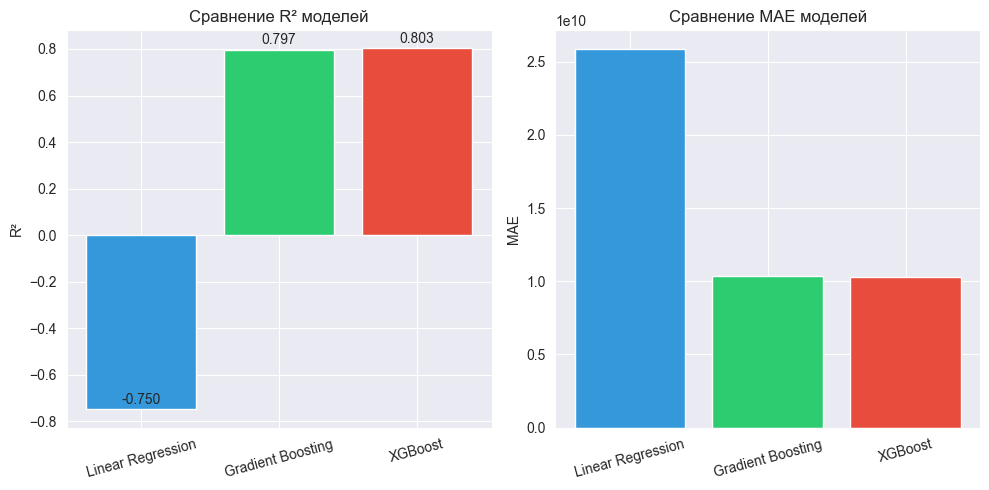


Лучшая модель по R²: XGBoost (R² = 0.803)


In [18]:
# Сравнительная таблица результатов всех моделей
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Gradient Boosting', 'XGBoost'],
    'R²': [r2_lr, r2_gb, r2_xgb],
    'MSE': [mse_lr, mse_gb, mse_xgb],
    'MAE': [mae_lr, mae_gb, mae_xgb],
    'CV R²': ['-', f'{cv_r2:.3f}', f'{cv_r2_xgb:.3f}']
})

print('Сравнение моделей:')
print(results.to_string(index=False))

# Визуализация сравнения R²
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
colors = ['#3498db', '#2ecc71', '#e74c3c']
bars = plt.bar(results['Model'], results['R²'], color=colors)
plt.ylabel('R²')
plt.title('Сравнение R² моделей')
plt.xticks(rotation=15)
for bar, val in zip(bars, results['R²']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(results['Model'], results['MAE'], color=colors)
plt.ylabel('MAE')
plt.title('Сравнение MAE моделей')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Вывод лучшей модели
best_model = results.loc[results['R²'].idxmax(), 'Model']
best_r2 = results['R²'].max()
print(f'\nЛучшая модель по R²: {best_model} (R² = {best_r2:.3f})')

# Вывод
Проект успешно демонстрирует, что *градиентный бустинг* и *XGBoost* значительно превосходят *линейную регрессию* для данной задачи.

*XGBoost* показал наилучшие результаты с R² = 0.803, что свидетельствует о хорошей предсказательной способности модели для прогнозирования рыночной капитализации компаний на основе финансовых показателей.